<a href="https://colab.research.google.com/github/JesusRiveroOrtega/heart_sounds_segmentation_ConvLSTM/blob/master/hearbeat_segmentation_model_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from scipy.io import wavfile as wf
import numpy as np
import random
from matplotlib import pyplot as plt
import csv
from scipy import signal
from google.colab import drive

# convlstm model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.utils import to_categorical
from matplotlib import pyplot


drive.mount('/content/drive')

Using TensorFlow backend.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
a_name = ''
p_name = ''
files = 0
target = [[[],[]]]
k = 0
AUDIO = np.zeros((21, 396900))
TARGET = np.zeros((3, 21, 396900))
with open('drive/My Drive/kaggle/heartbeat_sounds/set_a_timing.csv') as csv_file:  
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0    
    for row in csv_reader: 
      if line_count > 0:
        a_name = row[0].split('/')[1]
        if a_name == p_name:
          target[k][0].append(row[2])
          target[k][1].append(row[3])
          if row[2] == 'S1':
            TARGET[0, k-1, int(row[3])] = 1
          if row[2] == 'S2':
            TARGET[1, k-1, int(row[3])] = 1
        else:
          target.append([[row[2]],[row[3]]])
          
          fs, data = wf.read('drive/My Drive/kaggle/heartbeat_sounds/set_a/'+a_name)   
          fc = 410
          
          b, a = signal.butter(4, fc/(fs/2), 'low', analog=True)
          data = signal.filtfilt(b, a, data)
          data = signal.filtfilt(b, a, data)
          mean = np.mean(data)
          data = data-mean
          std = np.std(data)
          data/=std
          if np.shape(data)[0] < 396900:  
            
            tmp_data = np.pad(data, (0,int(396900 - np.shape(data)[0])), 'constant', constant_values=(0, 0))
            
            AUDIO[k, :] = np.interp(tmp_data, (tmp_data.min(), tmp_data.max()), (-1, +1))           
          else:      
            
            AUDIO[k, :] = np.interp(data, (data.min(), data.max()), (-1, +1))
          
          k += 1
        
      
      else:
        pass
      p_name = a_name      
      line_count+=1
AUDIO = np.interp(AUDIO, (AUDIO.min(), AUDIO.max()), (-1, +1))
#AUDIO_der = np.gradient(AUDIO, axis=1)
#AUDIO = np.concatenate((AUDIO, AUDIO))
target = target[1:]

In [0]:
AUDIO_r = np.ravel(AUDIO)
DATA_S1 = []
DATA_S2 = []
DATA_ZE = []
TARG_S1 = []
TARG_S2 = []
TARG_ZE = []
TARGET_r = np.reshape(TARGET, (3, -1))
tg = TARGET_r[0,:]+TARGET_r[1,:]
win = 0
width = 4000
overlap = 3000
while win < AUDIO_r.shape[0] - width:
  
  if (1 in TARGET_r[0, win:win+width]) and (0 in TARGET_r[1, win:win+width]):
    TARG_S1.append(np.array([1, 0, 0]))
    DATA_S1.append(AUDIO_r[win:win+width])
  if (0 in TARGET_r[0, win:win+width]) and (1 in TARGET_r[1, win:win+width]):
    TARG_S2.append(np.array([0, 1, 0]))
    DATA_S2.append(AUDIO_r[win:win+width])
  else:
    TARG_ZE.append(np.array([0, 0, 1]))
    DATA_ZE.append(AUDIO_r[win:win+width])
  win += overlap
  

In [0]:
print(TARGET[:, 0, :].shape)

(3, 396900)


In [0]:
S1 = np.hstack((np.array(DATA_S1), np.array(TARG_S1)))
S2 = np.hstack((np.array(DATA_S2), np.array(TARG_S2)))
ZE = np.hstack((np.array(DATA_ZE), np.array(TARG_ZE)))
#for i in range(0, 20):
  #S1 = S1[np.random.permutation(range(0, S1.shape[0])), :]
  #S2 = S2[np.random.permutation(range(0, S2.shape[0])), :]
  #ZE = ZE[np.random.permutation(range(0, ZE.shape[0])), :]

s1 = S1.shape[0]
s2 = S2.shape[0]
ze = ZE.shape[0]

if s1 > s2:
  S1_DAT = S1[0:s2,:]
  S2_DAT = S2
  ZE_DAT = ZE[0:s2,:]
if s2 > s1:
  S2_DAT = S2[0:s1,:]
  S1_DAT = S1
  ZE_DAT = ZE[0:s1,:]
  
TRAINING_SET_PREV = np.vstack((S1_DAT[0:int(S1_DAT.shape[0] * 0.8), :], S2_DAT[0:int(S2_DAT.shape[0] * 0.8), :], ZE_DAT[0:int(ZE_DAT.shape[0] * 0.8), :]))  
TESTING_SET_PREV = np.vstack((S1_DAT[int(S1_DAT.shape[0] * 0.8):, :], S2_DAT[int(S2_DAT.shape[0] * 0.8):, :], ZE_DAT[int(ZE_DAT.shape[0] * 0.8):, :]))

TRAINING_DATA = TRAINING_SET_PREV[:, 0:TRAINING_SET_PREV.shape[1] - 3]
TRAINING_TARG = TRAINING_SET_PREV[:, TRAINING_SET_PREV.shape[1] - 3:]

TESTING_DATA = TRAINING_SET_PREV[:, 0:TRAINING_SET_PREV.shape[1] - 3]
TESTING_TARG = TRAINING_SET_PREV[:, TRAINING_SET_PREV.shape[1] - 3:]

TRAINING_DATA = np.expand_dims(TRAINING_DATA, axis=2)
TESTING_DATA = np.expand_dims(TESTING_DATA, axis=2)
TRAINING_DATA = np.concatenate((TRAINING_DATA, np.gradient(TRAINING_DATA, axis=1)), axis=2)
TESTING_DATA = np.concatenate((TESTING_DATA, np.gradient(TESTING_DATA, axis=1)), axis=2)

In [0]:
!cd 'drive/My Drive' &&  ls

'Colab Notebooks'
'Información relevante.gdoc'
 kaggle
 model_HBS_V2_1_acc_95.87523946360153.json
 model_HBS_V2_2_acc_100.0.json
 model_HBS_V2_2_acc_33.33333333333333.json
 model_HBS_V2_2_acc_62.829736211031175.json
 model_HBS_V2_2_acc_68.94484412470024.json
 model_HBS_V2_2_acc_69.42446043165468.json
 model_HBS_V2_2_acc_70.38369304556355.json
 model_HBS_V2_2_acc_70.74340527577938.json
 model_HBS_V2_2_acc_84.29256594724221.json
 model_HBS_V2_2_acc_85.31175059952038.json
 model_HBS_V2_2_acc_85.4916067146283.json
 model_HBS_V2_2_acc_86.81055157304668.json
 model_HBS_V2_2_acc_86.89048763373486.json
 model_HBS_V2_2_acc_87.35011990407673.json
 model_HBS_V2_2_acc_88.08952838682728.json
 model_HBS_V2_2_acc_88.12949640287769.json
 model_HBS_V2_2_acc_89.848121521856.json
 model_HBS_V2_2_acc_90.64748201915305.json
 model_HBS_V2_2_acc_91.30695443645084.json
 model_HBS_V2_2_acc_91.36690647482014.json
 model_HBS_V2_2_acc_91.54676258992805.json
 model_HBS_V2_2_acc_93.4052757793765.json
 model_HBS_V2

In [0]:
from keras.models import model_from_json

# Model reconstruction from JSON file
with open('drive/My Drive/model_HBS_V2_2_acc_95.67169540229885.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights('drive/My Drive/weights_HBS_V2_2_acc_95.67169540229885.h5')

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 4, 1, 998, 32)     13184     
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 4, 1, 996, 64)     73984     
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 1, 994, 128)       295424    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 994, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 127232)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               38169900  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 903       
Total para

In [0]:
A = TESTING_DATA.reshape((TESTING_DATA.shape[0], 4, 1, -1, 2))
prediction_model_perf = model.predict(A)


In [0]:
np.array(['S1', 'S2', 'none'])

array(['S1', 'S2', 'none'], dtype='<U4')

Confusion matrix, without normalization
[[173   2   9]
 [  0 183   1]
 [ 14   0 170]]
Normalized confusion matrix
[[0.94 0.01 0.05]
 [0.   0.99 0.01]
 [0.08 0.   0.92]]


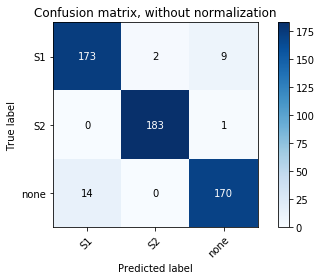

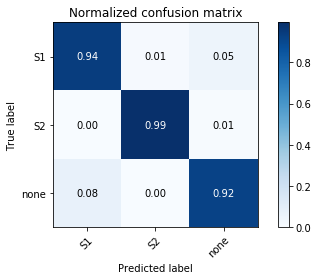

In [0]:
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
a = np.array(np.argmax(TESTING_TARG, axis=1))
b = np.array(np.argmax(prediction_model_perf, axis=1))
plot_confusion_matrix(a, b, classes=np.array(['S1', 'S2', 'none']), title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(a, b, classes=np.array(['S1', 'S2', 'none']), normalize=True,
                      title='Normalized confusion matrix')

plt.show()
cm = confusion_matrix(a, b)

In [0]:
true_positives_s1 = cm[0, 0]
#"TN of S1" is all non-S1 instances that are not classified as S1.
true_negatives_s1 = cm[1, 1] + cm[1, 2] + cm[2, 1] + cm[2, 2]
#"FP of S1" is all non-S1 instances that are classified as S1.
false_positives_s1 = cm[1, 0] + cm[2, 0]
#"FN of S1" is all S1 instances that are not classified as S1.
false_negatives_s1 = cm[0, 1] + cm[0, 2]

sensitivity_S1 = true_positives_s1/(true_positives_s1 + false_negatives_s1)
specificity_S1 = true_negatives_s1/(true_negatives_s1 + false_positives_s1)


true_positives_s2 = cm[1, 1]
#"TN of S2" is all non-S2 instances that are not classified as S2.
true_negatives_s2 = cm[0, 0] + cm[0, 2] + cm[2, 0] + cm[2, 2]
#"FP of S2" is all non-S2 instances that are classified as S2.
false_positives_s2 = cm[0, 1] + cm[2, 1]
#"FN of S2" is all S2 instances that are not classified as S2.
false_negatives_s2 = cm[1, 0] + cm[1, 2]

sensitivity_S2 = true_positives_s2/(true_positives_s2 + false_negatives_s2)
specificity_S2 = true_negatives_s2/(true_negatives_s2 + false_positives_s2)

true_positives_none = cm[2, 2]
#"TN of none" is all non-none instances that are not classified as none.
true_negatives_none = cm[0, 0] + cm[0, 1] + cm[1, 0] + cm[1, 1]
#"FP of none" is all non-none instances that are classified as none.
false_positives_none = cm[0, 2] + cm[1, 2]
#"FN of none" is all none instances that are not classified as none.
false_negatives_none = cm[2, 0] + cm[2, 1]

sensitivity_none = true_positives_none/(true_positives_none + false_negatives_none)
specificity_none = true_negatives_none/(true_negatives_none + false_positives_none)

print('Sensitivity S1 : ' + str(sensitivity_S1))
print('Specificity S1 : ' + str(specificity_S1))
print('Sensitivity S2 : ' + str(sensitivity_S2))
print('Specificity S2 : ' + str(specificity_S2))
print('Sensitivity none : ' + str(sensitivity_none))
print('Specificity none : ' + str(specificity_none))

Sensitivity S1 : 0.9402173913043478
Specificity S1 : 0.9619565217391305
Sensitivity S2 : 0.9945652173913043
Specificity S2 : 0.9945652173913043
Sensitivity none : 0.9239130434782609
Specificity none : 0.9728260869565217


In [0]:
from sklearn.metrics import recall_score, f1_score, precision_score
sensitivity = recall_score(a, b, average = None)
f1_score_v = f1_score(a, b, average=None)
precision = precision_score(a, b, average=None)
for i in range(0, sensitivity.shape[0] - 1):
  print('Sensitivity S' + str(i + 1) + ': ' + str(sensitivity[i]))
  print('\n')
  print('Precision S' + str(i + 1) + ': ' + str(precision[i]))
  print('\n')
  print('F1 Score S' + str(i + 1) + ': ' + str(f1_score_v[i]))
  print('\n')

i = 2
print('Sensitivity none: ' + str(sensitivity[i]))
print('\n')
print('Precision none: ' + str(precision[i]))
print('\n')
print('F1 Score none: ' + str(f1_score_v[i]))

Sensitivity S1: 0.9402173913043478


Precision S1: 0.9251336898395722


F1 Score S1: 0.9326145552560646


Sensitivity S2: 0.9945652173913043


Precision S2: 0.9891891891891892


F1 Score S2: 0.9918699186991871


Sensitivity none: 0.9239130434782609


Precision none: 0.9444444444444444


F1 Score none: 0.934065934065934


In [0]:
audio_example = AUDIO[0, :]
target_example = TARGET[:, 0, :]
prediction = []
target_comp = []
counter = 0
overlap = 3000
print(width)
while True:
  if counter+width > audio_example.shape[0]:
    target_example_piece = target_example[:, counter:counter+width]
    target_example_piece = np.hstack((target_example_piece, np.zeros((3, width - target_example_piece.shape[0]))))
    target_comp.append(target_example_piece)
    audio_example_piece = audio_example[counter:counter+width]
    audio_example_piece = np.hstack((audio_example_piece, np.zeros((width - audio_example_piece.shape[0]))))
    audio_example_piece = np.expand_dims(audio_example_piece, axis=1)
    audio_example_piece = np.expand_dims(audio_example_piece, axis=2)  
    audio_example_piece = np.concatenate((audio_example_piece, np.gradient(audio_example_piece, axis = 0)), axis=2)  
    audio_example_piece = audio_example_piece.reshape((1, 4, 1, -1, 2))
    prediction.append(model.predict(audio_example_piece))
    break
  else:
    target_example_piece = target_example[:, counter:counter+width]
    target_comp.append(target_example_piece)
    audio_example_piece = audio_example[counter:counter+width]
    audio_example_piece = np.expand_dims(audio_example_piece, axis=1)
    audio_example_piece = np.expand_dims(audio_example_piece, axis=2)  
    audio_example_piece = np.concatenate((audio_example_piece, np.gradient(audio_example_piece, axis = 0)), axis=2)  
    audio_example_piece = audio_example_piece.reshape((1, 4, 1, -1, 2))
    prediction.append(model.predict(audio_example_piece))
  
  counter += overlap
print()

4000



In [0]:
predicted_targ = np.zeros((audio_example.shape[0], 2))
counter = 0
window_number = 0
for pred in prediction:
  pred = pred[0]
  
  if overlap == 4000:
    if np.argmax(pred) == 0 and pred[np.argmax(pred)] > 0.01:
      predicted_targ[counter:counter+width, 0] = np.ones((width))
      
    if np.argmax(pred) == 1 and pred[np.argmax(pred)] > 0.9:
      predicted_targ[counter:counter+width, 1] = np.ones((width))
  else:
    if np.argmax(pred) == 0 and pred[np.argmax(pred)] > 0.01:
      predicted_targ[counter:counter+width, 0] = np.ones((predicted_targ[counter:counter+width, 0].shape[0]))
    if np.argmax(pred) == 1 and pred[np.argmax(pred)] > 0.9:
      predicted_targ[counter:counter+width, 1] = np.ones((predicted_targ[counter:counter+width, 1].shape[0]))
  counter += overlap

In [0]:
print(predicted_targ.shape)

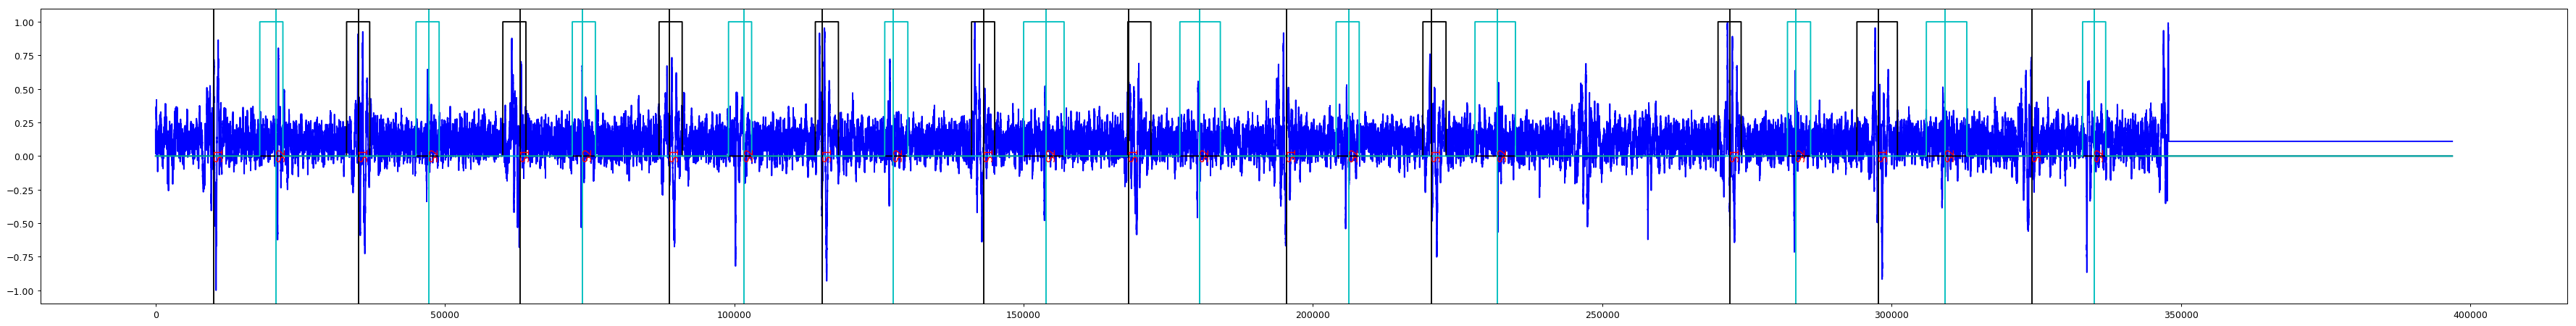

In [0]:
for i in range(0, 1):
  plt.figure(num=1, figsize=(50, 6), dpi=90, facecolor='w', edgecolor='k')
  plt.plot(audio_example, 'b')
  plt.plot(predicted_targ[:,0], 'k')
  plt.plot(predicted_targ[:,1], 'c')
  for k in range(0, len(target[i][0])):
    if target[i][0][k] == 'S1':
      plt.axvline(float(target[i][1][k]), color = 'k')
    else:
      plt.axvline(float(target[i][1][k]), color = 'c')
    plt.text(float(target[i][1][k]),0,target[i][0][k],rotation=90, fontsize = 12, color='r')
  plt.show()